<a href="https://colab.research.google.com/github/Vreyka/AIVN_learning_path/blob/main/Research/Eco/DL/LSTM_Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_data(timestep):
    data = []
    ranges = []

    total = 0
    while total < timestep:
        # Random độ dài của đoạn (elaps): ví dụ từ 20 đến 100
        elaps = np.random.randint(10, 100)

        # Giới hạn để không vượt quá tổng thời gian
        if total + elaps > timestep:
            elaps = timestep - total

        # Random khoảng giá trị
        low = np.random.randint(0, 100)
        width = np.random.randint(5, 50)
        high = low + width

        # Sinh giá trị trong đoạn này
        segment_data = np.random.random(low, high, size=elaps)
        data.extend(segment_data)
        ranges.append((elaps, low, high))
        total += elaps

    return np.array(data), ranges

# Ví dụ
timestep = 10000
# elaps = 50
ts, used_ranges = create_data(timestep)

# In các khoảng random đã dùng
# for i, (low, high) in enumerate(used_ranges):
#     print(f"Đoạn {i}: random trong khoảng [{low}, {high})")

# Vẽ
plt.plot(ts)
plt.title("Random Time Series with Varying Ranges")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.grid(True)
plt.show()


TypeError: random() takes at most 1 positional argument (2 given)

In [ ]:
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])  # lấy đầu ra tại thời điểm cuối
        return out


In [ ]:
def train_model(model, criterion, optimizer, train_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(ts.reshape(-1, 1)).flatten()

In [ ]:
# Tạo chuỗi
seq_len = 10
X, y = create_sequences(data_scaled, seq_len)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Convert to Tensor
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)

In [ ]:
# Khởi tạo model
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
train_model(model, criterion, optimizer, train_loader, epochs=100)

Epoch 1/100, Loss: 0.0124
Epoch 2/100, Loss: 0.0239
Epoch 3/100, Loss: 0.0088
Epoch 4/100, Loss: 0.0052
Epoch 5/100, Loss: 0.0174
Epoch 6/100, Loss: 0.0167
Epoch 7/100, Loss: 0.0077
Epoch 8/100, Loss: 0.0244
Epoch 9/100, Loss: 0.0068
Epoch 10/100, Loss: 0.0013
Epoch 11/100, Loss: 0.0123
Epoch 12/100, Loss: 0.0054
Epoch 13/100, Loss: 0.0312
Epoch 14/100, Loss: 0.0108
Epoch 15/100, Loss: 0.0059
Epoch 16/100, Loss: 0.0069
Epoch 17/100, Loss: 0.0040
Epoch 18/100, Loss: 0.0023
Epoch 19/100, Loss: 0.0160
Epoch 20/100, Loss: 0.0320
Epoch 21/100, Loss: 0.0088
Epoch 22/100, Loss: 0.0203
Epoch 23/100, Loss: 0.0117
Epoch 24/100, Loss: 0.0069
Epoch 25/100, Loss: 0.0132
Epoch 26/100, Loss: 0.0044
Epoch 27/100, Loss: 0.0263
Epoch 28/100, Loss: 0.0046
Epoch 29/100, Loss: 0.0036
Epoch 30/100, Loss: 0.0076
Epoch 31/100, Loss: 0.0099
Epoch 32/100, Loss: 0.0177
Epoch 33/100, Loss: 0.0072
Epoch 34/100, Loss: 0.0036
Epoch 35/100, Loss: 0.0254
Epoch 36/100, Loss: 0.0102
Epoch 37/100, Loss: 0.0041
Epoch 38/1


📊 Đánh giá:
✔️ MSE: 386.0609
✔️ MAE: 14.1935
✔️ R²:  0.7613


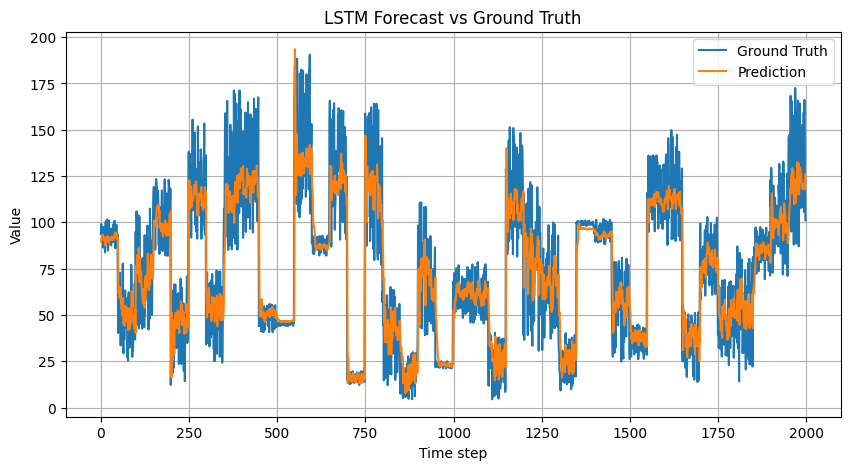

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_true = y_test.squeeze().numpy()

# Undo scale
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# ------------------------
# Đánh giá
# ------------------------
mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)

print(f"\n📊 Đánh giá:")
print(f"✔️ MSE: {mse:.4f}")
print(f"✔️ MAE: {mae:.4f}")
print(f"✔️ R²:  {r2:.4f}")

# ------------------------
# Vẽ biểu đồ
# ------------------------
plt.figure(figsize=(10, 5))
plt.plot(y_true_inv, label="Ground Truth")
plt.plot(y_pred_inv, label="Prediction")
plt.title("LSTM Forecast vs Ground Truth")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()